In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
from twitter.twitter_collection import TwitterCollection
from twitter.tweet_sentiment_analyzer import TweetSentimentAnalyzer
from data_pipelines.data_manipulation import DataManipulation
from dl_models.xgboost_forecaster import XgboostForecaster
from logger.logger import Logger


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

In [2]:
SYMBOL = 'BTC-USD'
SYMBOL_NAME = 'Bitcoin'
SYMBOL_CUT = 'btc'
scale = 1
range_list = [i for i in range(5,21)]
range_list = [i*scale for i in range_list]
interval = '1h'
start_date = '2020-06-30'
end_date = '2022-07-01'
source = 'yahoo'
LOG_PATH = '../logger' + os.sep + "logs"
LOG_FILE_NAME_PREFIX = f"log_{SYMBOL_CUT}_{start_date}_{end_date}"

logger = Logger(LOG_PATH, LOG_FILE_NAME_PREFIX)
tsa = TweetSentimentAnalyzer()
data = DataManipulation(SYMBOL, source, range_list, start_date=start_date, 
                        end_date=end_date, interval=interval, scale=scale, 
                        prefix_path='..', saved_to_csv=True,
                        logger=logger)
df_price = data.df.copy()

1 ) 26-12-2022 23_41_50 MainThread INFO\ Initialized logging at path ../logger/logs/log_btc_2020-06-30_2022-07-01_26-12-2022_23_41_50.log
2 ) 26-12-2022 23_41_51 MainThread DEBUG\ Get data from local file ../data/outputs/data_ind/BTC-USD/BTC-USD_df_2020-06-30_2022-07-01_1h.csv


In [18]:
df_price_ext = data.extract_features()
df_sasa_ext = data_sasa.extract_features()
close_col = df_price.loc['2021-01-01':'2022-06-27',['close','volume']].copy()

30 ) 26-12-2022 23_54_59 MainThread DEBUG\ Start helper function for Hisse strategy
31 ) 26-12-2022 23_54_59 MainThread DEBUG\ Hisse strategy, mfi and fischer scoring is finished
32 ) 26-12-2022 23_54_59 MainThread DEBUG\ Start ema normalized label


100%|██████████| 16/16 [00:00<00:00, 688.40it/s]


33 ) 26-12-2022 23_54_59 MainThread DEBUG\ Add ema normalized label
34 ) 26-12-2022 23_54_59 MainThread DEBUG\ Start mfi normalized label


100%|██████████| 16/16 [00:00<00:00, 1494.83it/s]


35 ) 26-12-2022 23_54_59 MainThread DEBUG\ Add mfi normalized label
36 ) 26-12-2022 23_54_59 MainThread DEBUG\ Start sma normalized label


100%|██████████| 16/16 [00:00<00:00, 498.03it/s]


37 ) 26-12-2022 23_54_59 MainThread DEBUG\ Add sma normalized label
38 ) 26-12-2022 23_54_59 MainThread DEBUG\ Start wma normalized label


100%|██████████| 16/16 [00:00<00:00, 377.49it/s]


39 ) 26-12-2022 23_54_59 MainThread DEBUG\ Add wma normalized label
40 ) 26-12-2022 23_54_59 MainThread DEBUG\ Start tema normalized label


100%|██████████| 16/16 [00:00<00:00, 30.45it/s]


41 ) 26-12-2022 23_55_00 MainThread DEBUG\ Add tema normalized label
42 ) 26-12-2022 23_55_00 MainThread DEBUG\ Start kama normalized label


100%|██████████| 16/16 [00:00<00:00, 29.57it/s]


43 ) 26-12-2022 23_55_00 MainThread DEBUG\ Add kama normalized label
44 ) 26-12-2022 23_55_00 MainThread DEBUG\ Start rsi normalized label


100%|██████████| 16/16 [00:00<00:00, 43.31it/s]


45 ) 26-12-2022 23_55_00 MainThread DEBUG\ Add rsi normalized label
46 ) 26-12-2022 23_55_01 MainThread DEBUG\ Add ADX indicator normalized label
47 ) 26-12-2022 23_55_01 MainThread DEBUG\ Normalized features for indicators values to 1 and 0
48 ) 26-12-2022 23_55_01 MainThread DEBUG\ Add Datetime fetures for extracted feature data
49 ) 26-12-2022 23_55_03 MainThread DEBUG\ Lags for features and log return vol_delta with binary label
50 ) 26-12-2022 23_55_03 MainThread DEBUG\ Add KZ score and Index label
logs written...


In [4]:
sent_tweets = pd.read_csv('btc_archieve/btc_hourly_sent_score.csv')
#sent_tweets = pd.read_csv('../data/tweets_data/btc/btc_hour.csv')
sent_tweets.Datetime = pd.to_datetime(sent_tweets.Datetime)
sent_tweets.set_index('Datetime', inplace=True, drop=True)

In [5]:
sent_tweets.index = sent_tweets.index.tz_convert(None)

In [19]:
df_price_ext.head()

,st_stoch,st_ich,st_cut_ema5_sma10,st_macd,st_ich_close,st_dmi,st_cut_sma10_close,st_hisse,st_mfi,st_fishert,...,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,feature_label,kz_score
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-14 12:30:00+03:00,0,0,0,0,0,0,1,0,2,2,...,1,0,0,1,1,0,0,1,1.0000,0.9227
2022-01-14 13:30:00+03:00,0,0,0,0,0,0,1,0,2,2,...,0,0,1,1,0,0,1,1,0.0000,0.9746
2022-01-14 14:30:00+03:00,1,0,0,0,0,0,1,0,2,2,...,0,1,1,0,0,1,1,0,0.0000,0.9953
2022-01-14 15:30:00+03:00,0,0,0,0,0,0,1,0,2,2,...,1,1,0,0,1,1,0,0,1.0000,0.9639
2022-01-14 16:30:00+03:00,1,0,1,1,0,0,0,0,2,2,...,1,0,0,1,1,0,0,1,0.0000,1.8301


In [7]:
df_final = tsa.concat_ohlc_compound_score(df_price_ext, sent_tweets)
#df_final = df_final.loc['2021-01-01':,:].copy()
df_final.dropna(inplace=True)


Concantenation for sentiment score tweets and indicator MAtrix data


Text(0.5, 1.0, 'Bitcoin Proce')

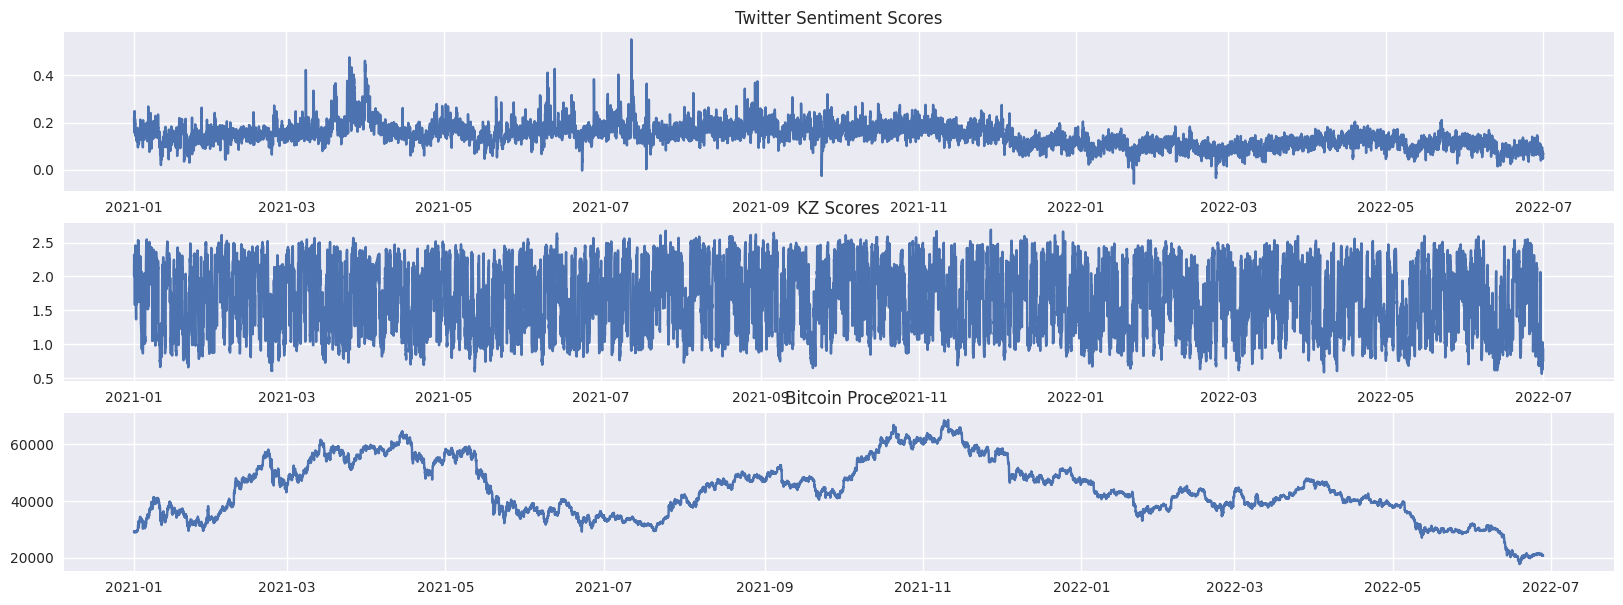

In [9]:
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(20,7))
ax1.plot(df_final.compound_total)
ax1.set_title('Twitter Sentiment Scores')
ax2.plot(df_final.index, df_final.kz_score)
ax2.set_title('KZ Scores')
ax3.plot(close_col.index, close_col.close)
ax3.set_title('Bitcoin Proce')

In [21]:
y = df_final.feature_label
X = df_final.drop(columns=['feature_label'], axis=1)



In [12]:
df_extra = df_price.copy()
df_extra['twitter_ssentiment'] = df_final.compound_total
df_extra['kz_score'] = df_final.kz_score
data.add_lags(df_extra, df_extra, 7)
df_extra.dropna(inplace=True)
df_extra.head()

,ad,adx_10,adx_11,adx_12,adx_13,adx_14,adx_15,adx_16,adx_17,adx_18,...,wma_8,wma_9,feature_label,twitter_ssentiment,kz_score,lag_2,lag_3,lag_4,lag_5,lag_6
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,1353224.7967,14.2722,13.8931,13.5759,13.2893,13.0159,12.7498,12.4955,12.2424,11.9900,...,28982.7792,28960.3413,1.0000,0.2208,2.0033,0,1,0,0,0
2021-01-01 01:00:00,1357355.4698,14.8220,14.2360,13.7798,13.4004,13.0654,12.7588,12.4779,12.2081,11.9457,...,29089.0350,29068.2213,0.0000,0.1708,2.3200,1,0,0,0,0
2021-01-01 02:00:00,1356001.9213,15.3169,14.5478,13.9668,13.5029,13.1113,12.7673,12.4614,12.1757,11.9039,...,29124.1592,29110.1580,1.0000,0.1684,2.2414,0,0,0,0,0
2021-01-01 03:00:00,1356269.8368,15.7622,14.8312,14.1382,13.5975,13.1540,12.7751,12.4459,12.1453,11.8644,...,29168.9389,29155.0073,0.0000,0.1578,2.2773,0,0,0,0,1
2021-01-01 04:00:00,1356360.2557,15.0556,14.2086,13.5794,13.0914,12.6938,12.3556,12.0627,11.7949,11.5438,...,29190.2383,29179.2131,0.0000,0.2447,2.2303,0,0,0,1,1


In [31]:
y = (df_extra.log_return > 0).astype(int)
X = df_extra.drop(columns=['log_return', 'daily_return', 'candlestick_pattern'], axis=1)

Creating X_train, X_test, y_train, y_test, evalset
[0]	validation_0-logloss:0.68407	validation_1-logloss:0.68433
[1]	validation_0-logloss:0.67516	validation_1-logloss:0.67567
[2]	validation_0-logloss:0.66644	validation_1-logloss:0.66718
[3]	validation_0-logloss:0.65788	validation_1-logloss:0.65885
[4]	validation_0-logloss:0.64948	validation_1-logloss:0.65068
[5]	validation_0-logloss:0.64127	validation_1-logloss:0.64266
[6]	validation_0-logloss:0.63322	validation_1-logloss:0.63480
[7]	validation_0-logloss:0.62531	validation_1-logloss:0.62709
[8]	validation_0-logloss:0.61755	validation_1-logloss:0.61951
[9]	validation_0-logloss:0.60993	validation_1-logloss:0.61208
[10]	validation_0-logloss:0.60246	validation_1-logloss:0.60480
[11]	validation_0-logloss:0.59513	validation_1-logloss:0.59765
[12]	validation_0-logloss:0.58792	validation_1-logloss:0.59062
[13]	validation_0-logloss:0.58084	validation_1-logloss:0.58371
[14]	validation_0-logloss:0.57388	validation_1-logloss:0.57693
[15]	validatio

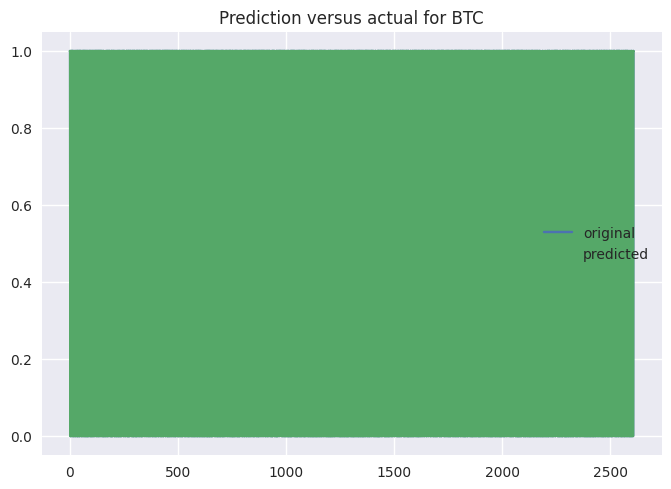

In [32]:
#y = (df_final.feature_label > 0).astype(int)                            #df_final.feature_label
#df_final.drop(columns=['feature_label'], axis=1)
from sklearn.metrics import accuracy_score, confusion_matrix

eval_metric = 'logloss'
eval_metric = None
xgb = XgboostForecaster(objective='binary', n_estimators=500, eta=0.01, max_depth=7, 
                    tree_method='gpu_hist', eval_metric='logloss')
xgb.create_train_test_data(X, y, test_size=0.2)
xgb.fit()
xgb.save_model(f'../dl_models/model_stack/model_price_{interval}_feature_numbers_{X.shape[1]}.json')
score = xgb.get_score()
print(f'first score: {score}')
#xgb.plot_learning_curves()
xgb.get_model_names('../dl_models/model_stack/')
#best_params = xgb.bestparams_gridcv([100, 200], [0.1], [1, 3], verbose=3)

ytest = xgb.y_test
ypred_reg = xgb.model.predict(xgb.X_test)
#print(f'Last accuracy: {accuracy_score(ytest, ypred_reg)}')
#print(f'Confusion Matrix: {confusion_matrix(ytest, ypred_reg)}')
x_ax = range(len(xgb.y_test))
plt.plot(x_ax, ytest, label="original")
plt.plot(x_ax, ypred_reg, label="predicted")
plt.title("Prediction versus actual for BTC")
plt.legend()
plt.show()
#yhat = (xgb.model.predict(xgb.X_test) > 0).astype(int)
#y_ = (xgb.y_test > 0).astype(int)
#accuracy = accuracy_score(yhat, y_)
#print('Accuracy: %.3f' % accuracy)

{'stoch_k': 0.2767204, 'candle_label': 0.059634164, 'stoch_d': 0.04681101, 'cci_5': 0.017457386, 'cmo_15': 0.014308362, 'roc_5': 0.013570405, 'willr_13': 0.013218937, 'cmo_5': 0.013069771, 'willr_8': 0.011186918, 'willr_9': 0.011013396}


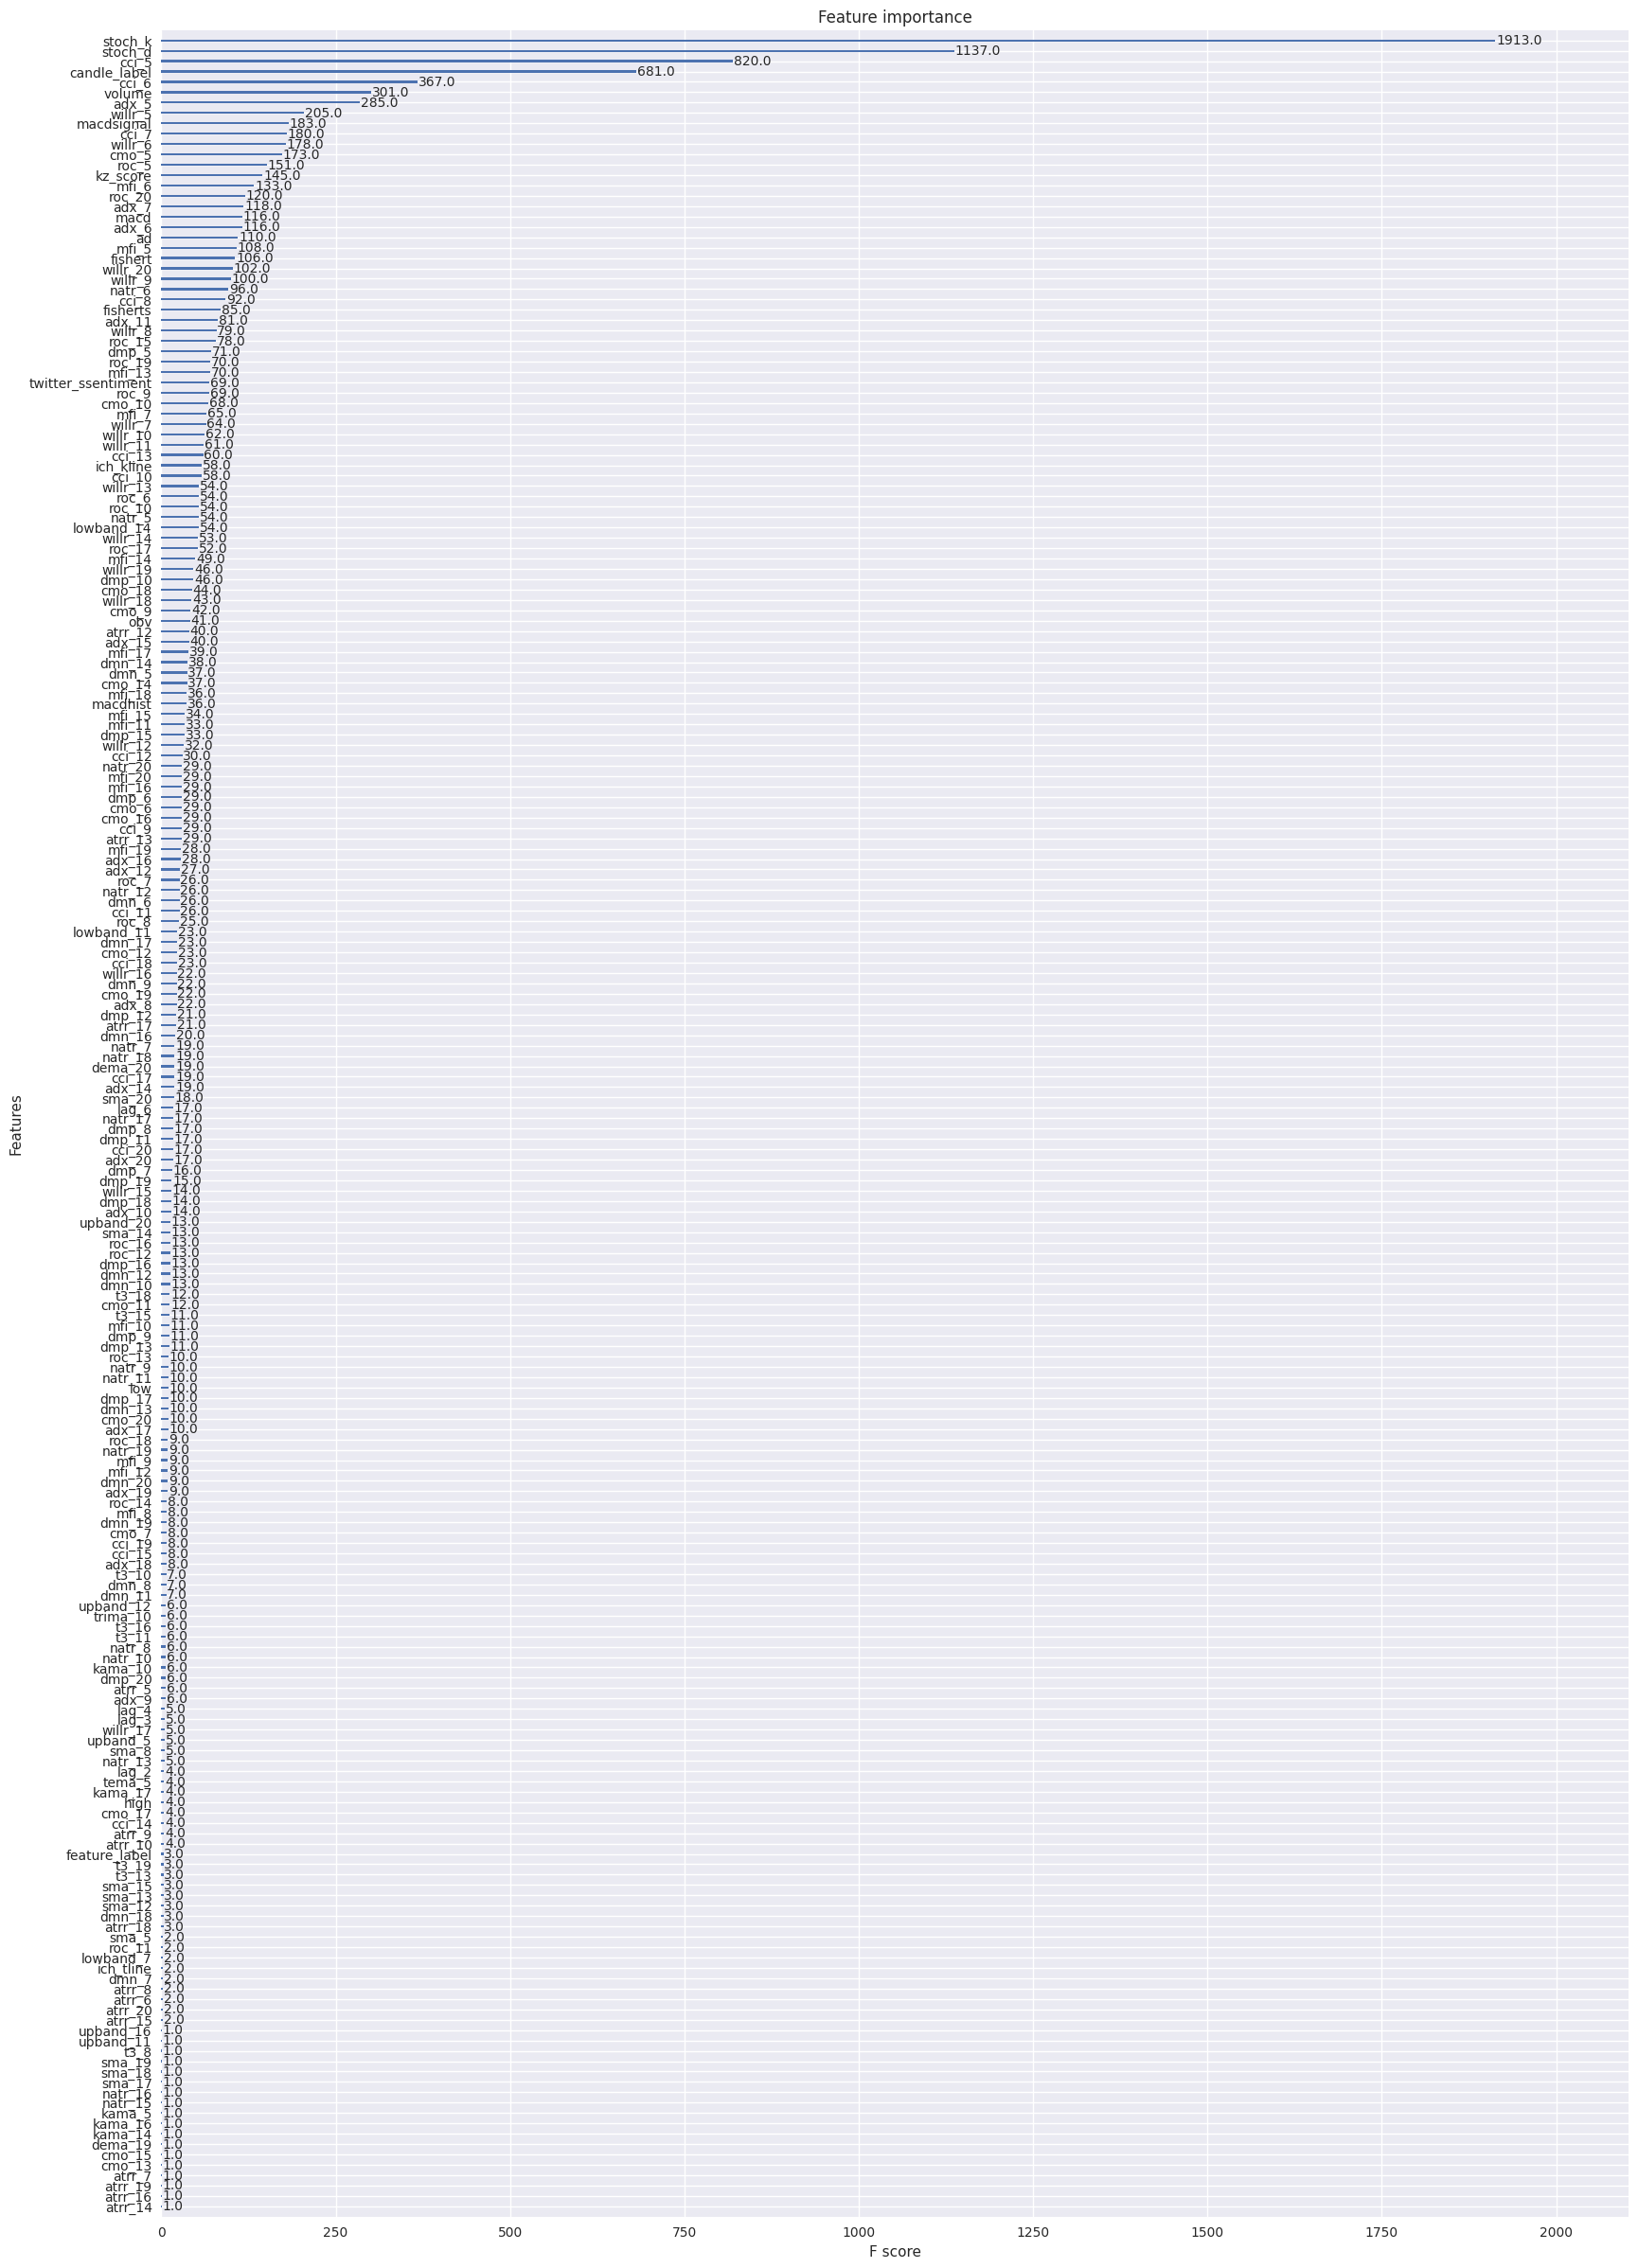

In [33]:
n_feat = xgb.get_n_importance_features(10)
print(n_feat)

xgb.plot_fature_importance()

Learning curves ploting and saved


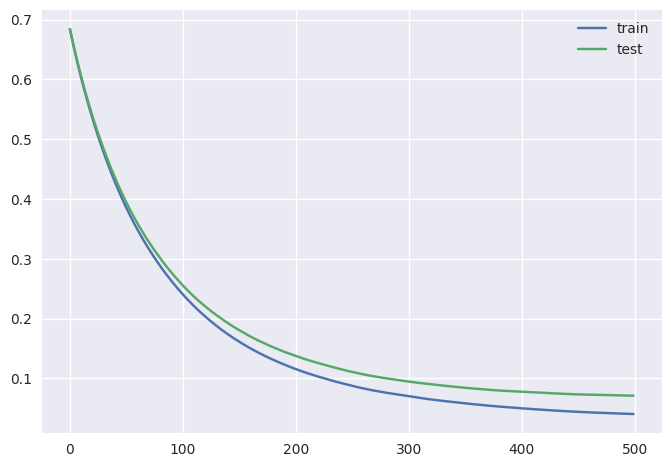

In [34]:
xgb.plot_learning_curves()